In [10]:
from networkx.algorithms.dag import dag_longest_path
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from trankit import Pipeline
from tqdm.auto import tqdm
tqdm.pandas()

import json
import math
import networkx as nx
import numpy as np
import pandas as pd
import re
import string
import pickle
import hashlib

POS_TAGS = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"]
CONTENT_WORD_TAGS = ["ADJ", "ADV", "NOUN", "PROPN", "VERB"]
DEP_RELS = [
    "acl",
    "acl:relcl",
    "advcl",
    "advmod",
    "amod",
    "appos",
    "aux",
    "aux:pass",
    "case",
    "cc",
    "cc:preconj",
    "ccomp",
    "compound",
    "compound:prt",
    "conj",
    "cop",
    "csubj",
    "det",
    "det:predet",
    "discourse",
    "expl",
    "fixed",
    "flat",
    "goeswith",
    "iobj",
    "list",
    "mark",
    "nmod",
    "nmod:npmod",
    "nmod:poss",
    "nmod:tmod",
    "nsubj",
    "nsubj:pass",
    "nummod",
    "obj",
    "obl",
    "obl:npmod",
    "obl:tmod",
    "parataxis",
    "punct",
    "root",
    "vocative",
    "xcomp",
]

In [11]:
# UD Features

def calc_ttr(items):
    """ Type-token ratio"""
    return len(set(items)) / len(items)


def get_avg_max_depth(parse):
    """Average depth of parse tree, code partially lifted from ud-boxer."""
    max_depths = []
    for sentence_idx, sentence in enumerate(parse["sentences"]):
        G = nx.DiGraph()
        nodes, edges = [], []

        for token in sentence["tokens"]:
            tok_id = (sentence_idx, token["id"])
            tok_data = {
                "_id": tok_id,
                "token": token["text"],
                "lemma": token.get("lemma"),
            }

            if token["head"] != 0:
                head_id = (sentence_idx, token["head"])
            else:
                head_id = None

            nodes.append((tok_id, tok_data))

            edge_data = {
                "token": token["deprel"],
                "deprel": token["deprel"],
            }

            if head_id:
                edges.append((head_id, tok_id, edge_data))

        G.add_nodes_from(nodes)
        G.add_edges_from(edges)

        max_depths.append(len(dag_longest_path(G)))
    return sum(max_depths) / len(max_depths)


def get_avg_link_len(parse_tree):
    """The average tokens between a head and its dependent (excluding punct)"""
    items = []
    for sent in parse_tree.values():
        for tok in sent.values():
            if (tok["head"] == 0) or (tok["deprel"] == "punct"):
                continue
            items.append(tok["head"] - tok["id"] + 1)
    return sum(items) / len(items)


def get_avg_max_link_len(parse_tree):
    """The average max tokens between a head and its dependent (excluding punct)"""
    items = []
    for sent in parse_tree.values():
        per_sent = []
        for tok in sent.values():
            if (tok["head"] == 0) or (tok["deprel"] == "punct"):
                continue
            per_sent.append(tok["head"] - tok["id"] + 1)
        if len(per_sent) > 1:
            items.append(max(per_sent))
    return sum(items) / len(items)


def get_max_link_len(parse_tree):
    """The max tokens between a head and its dependent (excluding punct)"""
    items = []
    for sent in parse_tree.values():
        for tok in sent.values():
            if (tok["head"] == 0) or (tok["deprel"] == "punct"):
                continue
            items.append(tok["head"] - tok["id"] + 1)
    return max(items) if len(items) > 0 else 0


def extract_ud_features(parse):
    """
    Reconstructing as many Profiling-UD features as possible.
    When this was not possible or unclear, the feature is a 0.

    Apologies for the code.
    """
    # unpack ids for easy traversal
    parse_tree = {
        sent["id"]: {tok["id"]: tok for tok in sent["tokens"]}
        for sent in parse["sentences"]
    }

    features = dict()

    all_tokens = [tok for sent in parse["sentences"] for tok in sent["tokens"]]
    all_words = [tok for tok in all_tokens if tok["upos"] != "PUNCT"]
    all_verbs = [tok for tok in all_tokens if tok["upos"] == "VERB"]
    all_aux = [tok for tok in all_tokens if tok["upos"] == "AUX"]
    all_roots = [tok for tok in all_tokens if tok["head"] == 0]
    all_tokens_lemma = [tok["lemma"] for tok in all_tokens]
    # does this need to be lowered? word forms...?
    all_tokens_text = [tok["text"] for tok in all_tokens]

    features["n_sentences"] = np.log(len(parse["sentences"])) + 0.1
    features["n_tokens"] = np.log(len(all_tokens)) + 0.1
    features["tokens_per_sent"] = features["n_tokens"] / features["n_sentences"]
    features["char_per_tok"] = sum(len(tok) for tok in all_words) / len(all_tokens)

    features["ttr_lemma_chunks_100"] = calc_ttr(all_tokens_lemma[:100])
    features["ttr_lemma_chunks_200"] = calc_ttr(all_tokens_lemma[:200])
    features["ttr_form_chunks_100"] = calc_ttr(all_tokens_text[:100])
    features["ttr_form_chunks_200"] = calc_ttr(all_tokens_text[:200])

    for pos in POS_TAGS:
        features[f"upos_dist_{pos}"] = 100 * (
            sum(1 for tok in all_tokens if tok["upos"] == pos) / len(all_tokens)
        )

    features["lexical_density"] = sum(
        1 for tok in all_words if tok["upos"] in CONTENT_WORD_TAGS
    ) / len(all_words)

    # probably have to do this differently since there are more possible items,
    # maybe they chose these since they are present in most (all?) languages in UD
    morph_feats = [
        ("Tense", "tense", ["Past", "Pres"]),
        ("Mood", "mood", ["Imp", "Ind"]),
        ("VerbForm", "form", ["Fin", "Ger", "Inf", "Part"]),
    ]

    for key, label, items in morph_feats:
        for item in items:
            for sel_label, selection in [("verbs", all_verbs), ("aux", all_aux)]:
                if len(selection) == 0:
                    dist = 0
                else:
                    dist = 100 * (
                        sum(
                            1
                            for tok in selection
                            if f"{key}={item}" in tok.get("feats", dict())
                        )
                        / len(selection)
                    )

                features[f"{sel_label}_{label}_dist_{item}"] = dist

    # these don't make much sense in profiling-ud wrt missing info, just for consistency
    for sel_label, selection in [("verbs", all_verbs), ("aux", all_aux)]:
        # there has to be a better way, I think the loose '+' in profiling-ud is a mistake and it happens when both
        # 'Person' and 'Number' are not present in the parse.
        # for tok in selection:
        # key = None
        # if ('Number' not in tok['feats']) and ('Person' not in tok['feats']):
        # key =
        features[f"{sel_label}_num_pers_dist_+"] = 0  # skip for now
        features[f"{sel_label}_num_pers_dist_Sing+3"] = 0
    features["aux_num_pers_dist_Sing+1"] = 0

    # not sure if this is correct, verbal heads... per sent? or in total?
    verb_heads, total_heads = 0, 0
    for sent_id, sent in parse_tree.items():
        for tok in sent.values():
            # root, no head to count
            if tok["head"] == 0:
                continue
            if parse_tree[sent_id][tok["head"]]["upos"] == "VERB":
                verb_heads += 1
            total_heads += 1

    features["verbal_head_per_sent"] = 100 * (verb_heads / total_heads)
    features["verbal_root_perc"] = (
        0
        if len(all_roots) == 0
        else 100
        * (sum(1 for tok in all_roots if tok["upos"] == "VERB") / len(all_roots))
    )

    # having a hard time figuring out what these are
    features["avg_verb_edges"] = 0
    features["verb_edges_dist_0"] = 0
    features["verb_edges_dist_1"] = 0
    features["verb_edges_dist_2"] = 0
    features["verb_edges_dist_3"] = 0
    features["verb_edges_dist_4"] = 0
    features["verb_edges_dist_5"] = 0
    features["verb_edges_dist_6"] = 0

    features["avg_max_depth"] = get_avg_max_depth(parse)
    features["avg_token_per_clause"] = 0  # not sure
    features["avg_max_links_len"] = get_avg_max_link_len(parse_tree)
    features["avg_links_len"] = get_avg_link_len(parse_tree)
    features["max_links_len"] = get_max_link_len(parse_tree)
    features["avg_prepositional_chain_len"] = 0  # not sure
    features["n_prepositional_chains"] = 0  # not sure
    features["prep_dist_1"] = 0  # not sure
    features["prep_dist_2"] = 0
    features["prep_dist_3"] = 0
    features["prep_dist_4"] = 0

    # what is the order here? token order or dependency order?
    features["obj_pre"] = 0
    features["obj_post"] = 0
    features["subj_pre"] = 0
    features["subj_post"] = 0

    for dep_rel in DEP_RELS:
        features[f"dep_dist_{dep_rel}"] = 100 * (
            sum(1 for tok in all_tokens if tok["deprel"] == dep_rel) / len(all_tokens)
        )

    # not sure how this works
    features["principal_proposition_dist"] = 0
    features["subordinate_proposition_dist"] = 0
    features["subordinate_post"] = 0
    features["subordinate_pre"] = 0
    features["avg_subordinate_chain_len"] = 0
    features["subordinate_dist_1"] = 0
    features["subordinate_dist_2"] = 0
    features["subordinate_dist_3"] = 0
    features["subordinate_dist_4"] = 0
    features["subordinate_dist_5"] = 0

    return features

In [12]:
# Surface and readability features
def syllable(t):
    """Syllables per token"""
    return len(re.findall("[aeiou]", t))


def extract_additional_features(text, tokens, n_sentences):
    features = dict()

    for punct in string.punctuation:
        features[f"n_{punct}"] = text.count(punct)

    features["tot_syl"] = sum(syllable(y) for y in tokens)
    features["avg_syl"] = sum(syllable(y) for y in tokens) / len(tokens)

    # reading ease
    # len of sentence total used instead of split
    features["flesch"] = -1 * (
        206.385 - (1.015 * len(text)) - (84.6 * features["avg_syl"])
    )

    features["single_syl"] = sum(1 for y in tokens if syllable(y) == 1)

    features["flesch_mod"] = -1 * (
        1.599 * features["single_syl"] - 1.015 * len(text) - 31.517
    )

    # hard words are those with more than 2 syllables
    features["hard_words"] = sum(1 for y in tokens if syllable(y) > 2)
    features["gunning_fog"] = 0.4 * (len(text) + features["hard_words"])

    features["mod_smog"] = 3 + math.sqrt(features["hard_words"])

    # lix
    num_words = len(tokens)
    num_long_words = sum(1 for word in tokens if len(word) > 6)
    n_sentences = n_sentences if n_sentences > 0 else 1

    features["lix"] = num_words / n_sentences + (num_long_words * 100) / num_words

    return features

In [13]:
class Model:
    def __init__(
        self, 
        model_path=None, 
        gpu=False, 
        trankit_dir='.cache/', 
        parse_dir='data/ud-parse/'
    ) -> None:
        self.pipeline = Pipeline("english", gpu=gpu, cache_dir=trankit_dir)
        self.pipeline.add("dutch")
        self.pipeline.set_auto(True)

        with open(model_path, "rb") as f:
            self.model = pickle.load(f)

        self.parse_dir = Path(parse_dir)

    def featurize(self, text):
        name = f"{hashlib.md5(text.encode('utf8')).hexdigest()}.json"
        path = self.parse_dir / name
        if path.exists():
            with open(path) as f:
                parse = json.load(f)
        else:
            parse = self.pipeline(text)
            with open(path, 'w') as f:
                json.dump(parse, f, ensure_ascii=False)

        ud_features = extract_ud_features(parse)

        tokens = [
            tok["text"].lower()
            for sent in parse["sentences"]
            for tok in sent["tokens"]
        ]
        n_sents = len(parse["sentences"])
        extra_features = extract_additional_features(text, tokens, n_sents)

        all_features = {**ud_features, **extra_features}

        # sort items alphabetically to make sure the clf has the correct order
        feats = [
            item[1]
            for item in sorted(list(all_features.items()), key=lambda x: x[0])
        ]
        return feats


    def predict(self, texts):
        predictions = []
        for text in tqdm(texts, total=len(texts)):
            predictions.append(self.model.predict(np.array([self.featurize(text)]))[0])
        return predictions

In [14]:
# due to copyright reasons, we cannot add the human-written texts
# please contact the shared task organizers for the data
data_path = Path('data')

# merge all files and splits into a single df
dfs = []
for item in data_path.glob("*.csv"):
    lang = item.stem.split("_")[-1]
    temp_df = pd.read_csv(item)
    temp_df["language"] = lang
    dfs.append(temp_df)

df = pd.concat(dfs)
# rename unnamed ids column
df.rename(columns={df.columns[0]: "id"}, inplace=True)
df.head()

,id,text,label,genre,language
0,0,"Nikon, a renowned camera manufacturer, gained ...",1,News,en
1,1,The Taliban has gained control over nearly all...,1,News,en
2,2,As the Florida Legislature prepares to take a ...,0,News,en
3,3,Standard & Poor's Ratings Services has taken a...,1,News,en
4,4,"For 20 years, Representative George W. Gekas o...",0,News,en


In [6]:
# Cache parse trees
parse_dir = Path().resolve() / 'data/ud-parse/'
parse_dir.mkdir(exist_ok=True, parents=True)

model = Model(
    model_path='./svm_all_features_all_languages_all_domains.pickle',
    trankit_dir='.cache',
    parse_dir=parse_dir
)

Loading pretrained XLM-Roberta, this may take a while...
Loading tokenizer for english
Loading tagger for english
Loading lemmatizer for english
Loading NER tagger for english
Active language: english
Loading tokenizer for dutch
Loading tagger for dutch
Loading lemmatizer for dutch
Loading NER tagger for dutch
Turning on auto mode for ['english', 'dutch'] ...
Trankit is in auto mode!


In [ ]:
tqdm.pandas()

X = df['text'].progress_apply(model.featurize).apply(np.array)
y = df['label'].to_numpy()

In [16]:
X = np.vstack(np.ravel(X))

In [17]:
feature_names = ['aux_form_dist_Fin', 'aux_form_dist_Ger', 'aux_form_dist_Inf', 'aux_form_dist_Part', 'aux_mood_dist_Imp', 'aux_mood_dist_Ind', 'aux_num_pers_dist_+', 'aux_num_pers_dist_Sing+1', 'aux_num_pers_dist_Sing+3', 'aux_tense_dist_Past', 'aux_tense_dist_Pres', 'avg_links_len', 'avg_max_depth', 'avg_max_links_len', 'avg_prepositional_chain_len', 'avg_subordinate_chain_len', 'avg_syl', 'avg_token_per_clause', 'avg_verb_edges', 'char_per_tok', 'dep_dist_acl', 'dep_dist_acl:relcl', 'dep_dist_advcl', 'dep_dist_advmod', 'dep_dist_amod', 'dep_dist_appos', 'dep_dist_aux', 'dep_dist_aux:pass', 'dep_dist_case', 'dep_dist_cc', 'dep_dist_cc:preconj', 'dep_dist_ccomp', 'dep_dist_compound', 'dep_dist_compound:prt', 'dep_dist_conj', 'dep_dist_cop', 'dep_dist_csubj', 'dep_dist_det', 'dep_dist_det:predet', 'dep_dist_discourse', 'dep_dist_expl', 'dep_dist_fixed', 'dep_dist_flat', 'dep_dist_goeswith', 'dep_dist_iobj', 'dep_dist_list', 'dep_dist_mark', 'dep_dist_nmod', 'dep_dist_nmod:npmod', 'dep_dist_nmod:poss', 'dep_dist_nmod:tmod', 'dep_dist_nsubj', 'dep_dist_nsubj:pass', 'dep_dist_nummod', 'dep_dist_obj', 'dep_dist_obl', 'dep_dist_obl:npmod', 'dep_dist_obl:tmod', 'dep_dist_parataxis', 'dep_dist_punct', 'dep_dist_root', 'dep_dist_vocative', 'dep_dist_xcomp', 'flesch', 'flesch_mod', 'gunning_fog', 'hard_words', 'lexical_density', 'lix', 'max_links_len', 'mod_smog', 'n_!', 'n_"', 'n_#', 'n_$', 'n_%', 'n_&', "n_'", 'n_(', 'n_)', 'n_*', 'n_+', 'n_,', 'n_-', 'n_.', 'n_/', 'n_:', 'n_;', 'n_<', 'n_=', 'n_>', 'n_?', 'n_@', 'n_[', 'n_\\', 'n_]', 'n_^', 'n__', 'n_`', 'n_prepositional_chains', 'n_sentences', 'n_tokens', 'n_{', 'n_|', 'n_}', 'n_~', 'obj_post', 'obj_pre', 'prep_dist_1', 'prep_dist_2', 'prep_dist_3', 'prep_dist_4', 'principal_proposition_dist', 'single_syl', 'subj_post', 'subj_pre', 'subordinate_dist_1', 'subordinate_dist_2', 'subordinate_dist_3', 'subordinate_dist_4', 'subordinate_dist_5', 'subordinate_post', 'subordinate_pre', 'subordinate_proposition_dist', 'tokens_per_sent', 'tot_syl', 'ttr_form_chunks_100', 'ttr_form_chunks_200', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'upos_dist_ADJ', 'upos_dist_ADP', 'upos_dist_ADV', 'upos_dist_AUX', 'upos_dist_CCONJ', 'upos_dist_DET', 'upos_dist_INTJ', 'upos_dist_NOUN', 'upos_dist_NUM', 'upos_dist_PART', 'upos_dist_PRON', 'upos_dist_PROPN', 'upos_dist_PUNCT', 'upos_dist_SCONJ', 'upos_dist_SYM', 'upos_dist_VERB', 'upos_dist_X', 'verb_edges_dist_0', 'verb_edges_dist_1', 'verb_edges_dist_2', 'verb_edges_dist_3', 'verb_edges_dist_4', 'verb_edges_dist_5', 'verb_edges_dist_6', 'verbal_head_per_sent', 'verbal_root_perc', 'verbs_form_dist_Fin', 'verbs_form_dist_Ger', 'verbs_form_dist_Inf', 'verbs_form_dist_Part', 'verbs_mood_dist_Imp', 'verbs_mood_dist_Ind', 'verbs_num_pers_dist_+', 'verbs_num_pers_dist_Sing+3', 'verbs_tense_dist_Past', 'verbs_tense_dist_Pres']

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

perm_importance = permutation_importance(model.model, X, y, scoring='accuracy')
sorted_idx = perm_importance.importances_mean.argsort()

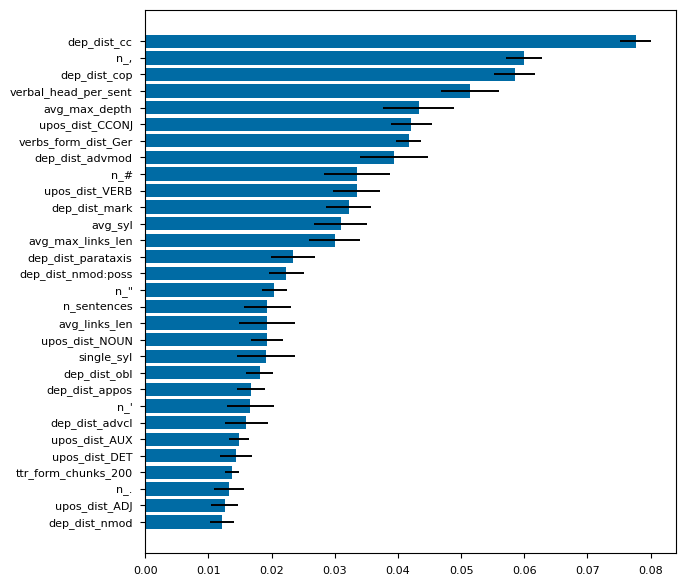

In [ ]:
feat_name = np.array(feature_names)

with plt.style.context('seaborn-v0_8-paper'):
    fig, ax = plt.subplots(figsize=(6,6))
    fig.tight_layout()

    indices = perm_importance.importances_mean.argsort()[-30:]
    xs = range(len(indices))
    plt.barh(
        xs,
        perm_importance.importances_mean[indices],
        xerr=perm_importance.importances_std[indices],
    )

    ax.set_yticklabels(feat_name[indices])

In [ ]:
from scipy.stats import pearsonr

results = []

for lang in df.language.unique():
    for domain in df.genre.unique():
        selection = (
            (df["genre"] == domain)
            & (df["language"] == lang)
        )
        if len(df[selection]) == 0:
            continue
        features = df[selection]['text'].apply(model.featurize).apply(np.array)
        features = np.vstack(np.ravel(features))
        labels = df[selection]['label']
        for i, f in enumerate(features.T):
            stat, p = pearsonr(f, labels)
            results.append(
                {
                    "domain": domain,
                    "language": lang,
                    "corr": stat,
                    "p": p,
                    "feature": feature_names[i],
                }
            )

In [10]:
df_res = pd.DataFrame().from_records(results)
df_res.head()

,domain,language,corr,p,feature
0,News,en,-0.067711,0.176525,aux_form_dist_Fin
1,News,en,-0.052554,0.294405,aux_form_dist_Ger
2,News,en,-0.019609,0.695803,aux_form_dist_Inf
3,News,en,0.161302,0.001207,aux_form_dist_Part
4,News,en,0.050063,0.317918,aux_mood_dist_Imp


[Text(0.5, 0, 'News-en'),
 Text(1.5, 0, 'Twitter-en'),
 Text(2.5, 0, 'Reviews-en'),
 Text(3.5, 0, 'Poetry-en'),
 Text(4.5, 0, 'Column-en'),
 Text(5.5, 0, 'Open-source-en'),
 Text(6.5, 0, 'News-nl'),
 Text(7.5, 0, 'Twitter-nl'),
 Text(8.5, 0, 'Reviews-nl'),
 Text(9.5, 0, 'Poetry-nl'),
 Text(10.5, 0, 'Column-nl')]

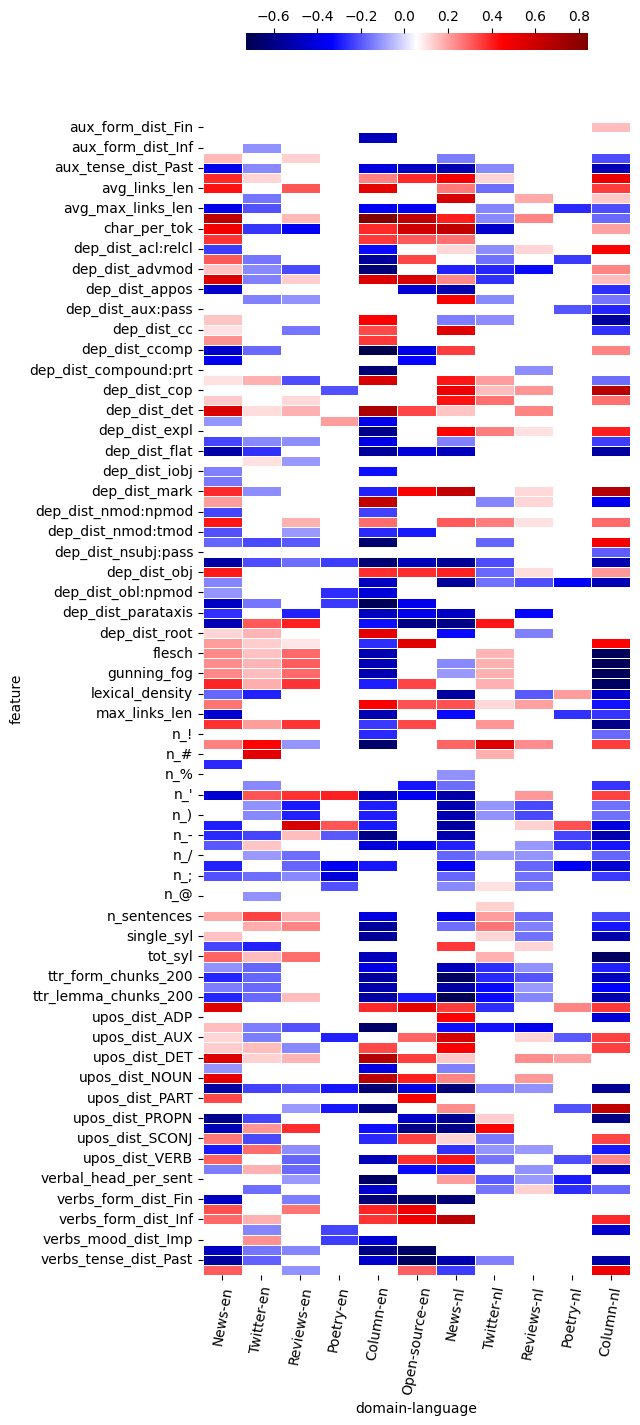

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sel = df_res[df_res['p'] < 0.05].pivot(values="corr", index="feature", columns=['domain', 'language'])
f, ax = plt.subplots(figsize=(5, 15))
f.tight_layout()
g = sns.heatmap(sel, linewidths=.5, ax=ax, cmap='seismic', cbar_kws={"shrink": 0.8, "location": 'top', "orientation": "horizontal"})
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)

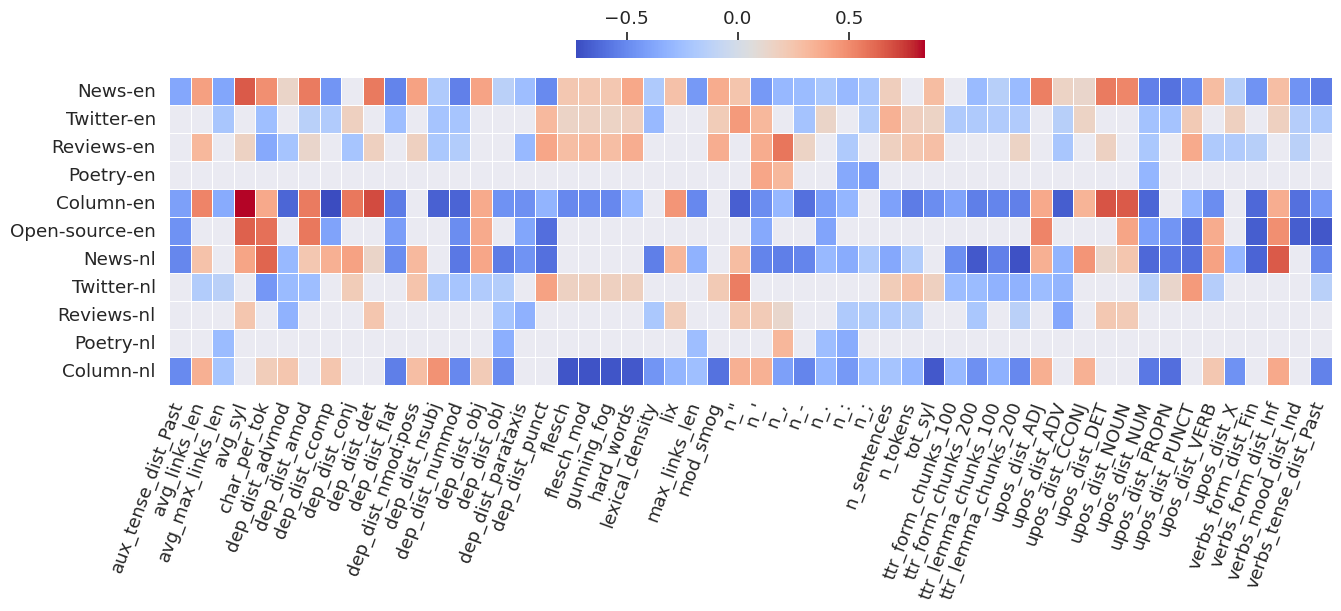

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
 

f, ax = plt.subplots(figsize=(15, 5))

# select only statistically significant correlations
sel = df_res[(df_res['p'] < 0.01)].pivot(values="corr", index="feature", columns=['domain', 'language'])
sel = sel.dropna(thresh=5) # drop 'rare' features
g = sns.heatmap(sel.transpose(), linewidths=0.5, ax=ax, cmap='coolwarm', cbar_kws={"shrink": 0.3, "location": 'top', "orientation": "horizontal"})


# matplotlib has a dpi of 72
dx = 5/72
dy = 0/72
offset = matplotlib.transforms.ScaledTranslation(dx, dy, f.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right", fontsize=13)

ax.grid(visible=False)
ax.set(xlabel=None)  
ax.set(ylabel=None)
ax.tick_params(left=False) 
ax.tick_params(bottom=False)

# uncomment to save figure
# f.get_figure().savefig('detectum-correlations.pdf', bbox_inches="tight")

In [16]:
sel

domain,News,Twitter,Reviews,Poetry,Column,Open-source,News,Twitter,Reviews,Poetry,Column
language,en,en,en,en,en,en,nl,nl,nl,nl,nl
feature,,,,,,,,,,,
aux_form_dist_Fin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155279
aux_form_dist_Ger,NaN,NaN,NaN,NaN,-0.482647,NaN,NaN,NaN,NaN,NaN,NaN
aux_form_dist_Inf,NaN,-0.109993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aux_form_dist_Part,0.161302,NaN,0.128962,NaN,NaN,NaN,-0.141166,NaN,NaN,NaN,-0.213861
aux_tense_dist_Past,-0.375608,-0.125788,NaN,NaN,-0.408648,-0.470689,-0.508918,-0.123346,NaN,NaN,-0.497044
...,...,...,...,...,...,...,...,...,...,...,...
verbs_form_dist_Part,NaN,-0.129019,NaN,-0.229629,NaN,NaN,NaN,NaN,NaN,NaN,-0.442390
verbs_mood_dist_Imp,NaN,0.227092,NaN,-0.241711,-0.422072,NaN,NaN,NaN,NaN,NaN,NaN
